<a href="https://colab.research.google.com/github/nevalenaginda/Cassava-Disease-Identification/blob/master/CNN_Cassava_Disease_V_1_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow
tensorflow.__version__

'2.3.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#%cd -
%cd drive/My Drive/Data Singkong

/content/drive/My Drive/Data Singkong


In [ ]:
!ls

'Model Oca'  'My Model'   test	 train


In [ ]:
import tensorflow as tf
print(tf.__version__)
tf.test.gpu_device_name()

2.3.0


'/device:GPU:0'

In [ ]:
import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import tensorflow.python.keras as keras

In [ ]:

base_path = 'train/'

categories = ['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']

In [ ]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [ ]:
print('length for each category:', [len(f) for f in fnames])

length for each category: [419, 483, 405, 493, 288]


In [ ]:
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [ ]:
print('number of images for each category:', [len(f) for f in images])

number of images for each category: [419, 483, 405, 493, 288]


In [ ]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

500,424 is the min shape for cbb
500,500 is the min shape for cbsd
500,500 is the min shape for cgm
500,499 is the min shape for cmd
347,464 is the min shape for healthy


In [ ]:
def cvtRGB(img):
    return cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)

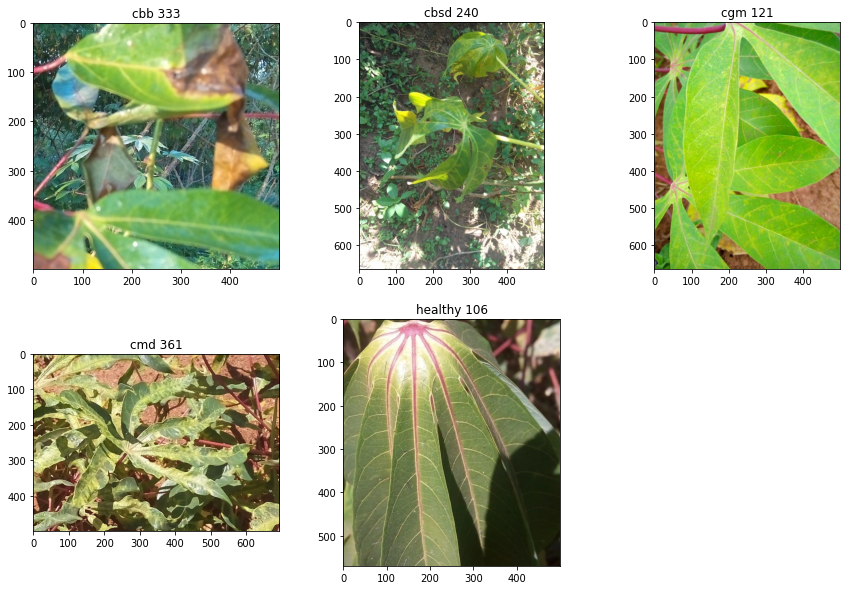

In [ ]:
plt.figure(figsize=(15,10))
for i, imgs in enumerate(images):
    plt.subplot(2,3,i+1)
    idx = np.random.randint(len(imgs))
    plt.imshow(cvtRGB(imgs[idx]))
    plt.grid(False)
    plt.title(categories[i]+' '+str(idx))
plt.show()

(666, 500, 3)
(224, 224, 3)


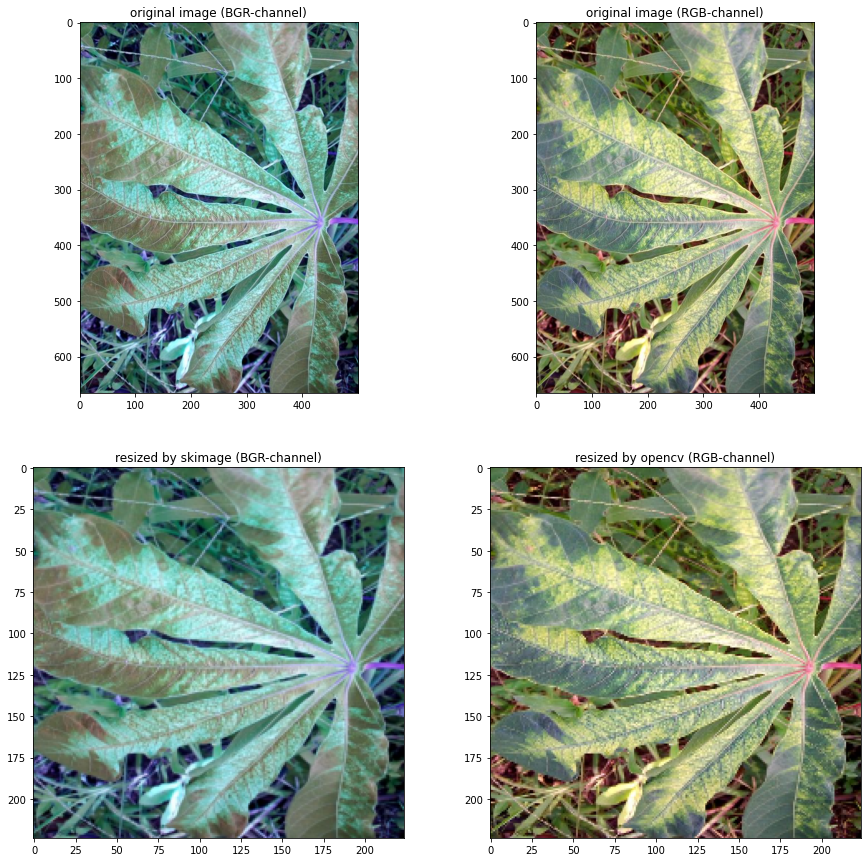

In [ ]:
img_width, img_height = 224, 224

img = images[3][100]
print(img.shape)
resized_img = resize(img, (img_width, img_height, 3))
resized_img2 = cv2.resize(img,(img_width, img_height), interpolation = cv2.INTER_CUBIC)
print(resized_img.shape)
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.title('original image (BGR-channel)')
plt.grid(False)
plt.imshow(img)
plt.subplot(2,2,2)
plt.title('original image (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(img))
plt.subplot(2,2,3)
plt.title('resized by skimage (BGR-channel)')
plt.grid(False)
plt.imshow((resized_img))
plt.subplot(2,2,4)
plt.title('resized by opencv (RGB-channel)')
plt.grid(False)
plt.imshow(cvtRGB(resized_img2))
plt.show()

In [ ]:
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [ ]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.75, test_size=0.25)
    train_images.append(train)
    val_images.append(test)

In [ ]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[314, 362, 303, 369, 216]
sum of train images: 1564
[105, 121, 102, 124, 72]
sum of val_images: 524


In [ ]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

In [ ]:
print('Before converting')
print('train data:', train_images.shape)
print('train labels:', train_categories.shape)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
#train_labels = tensorflow.keras.utils.to_categorical(train_categories, len(categories))
#val_labels = tensorflow.keras.utils.to_categorical(val_categories, len(categories))
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))
print()
print('After converting')
print('train data:', train_data.shape)
print('train labels:', train_labels.shape)

Before converting
train data: (1564, 224, 224, 3)
train labels: (1564,)

After converting
train data: (1564, 224, 224, 3)
train labels: (1564, 5)


In [ ]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)

In [ ]:
train_data = train_data[:len(train_data)]
train_labels = train_labels[:len(train_data)]
val_data = val_data[:len(val_data)]
val_labels = val_labels[:len(val_data)]
print('shape of train data:', train_data.shape)
print('shape of train labels:', train_labels.shape)
print('shape of val data:', val_data.shape)
print('shape of val labels:', val_labels.shape)

shape of train data: (1564, 224, 224, 3)
shape of train labels: (1564, 5)
shape of val data: (524, 224, 224, 3)
shape of val labels: (524, 5)


In [ ]:
IMG_SHAPE = (224, 224,3)
def create_mode_mobilenet():

  # Membuat model dasar (base model) dari pre-trained model MobileNet
  base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')
  base_model.trainable = False
  model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GaussianNoise(0.25),  
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(5, activation='softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.RMSprop(lr=0.0005), metrics=['acc'])
  return model

In [ ]:
batch_size = 32
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    horizontal_flip=True,
    vertical_flip=False,
    channel_shift_range = 0.1,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.7, 
                                                                    patience=5, verbose=2, mode='auto',
                                                                    min_lr=1e-7)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                             patience=6, verbose=10, mode='auto',
                                             baseline=None, restore_best_weights=True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint("My Model/best_model.h5", monitor='val_acc', mode='max', verbose=2, save_best_only=True)

In [ ]:
mobile_net = create_mode_mobilenet()
EPOCHS= 300

start = time.time()
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size + 1
STEP_SIZE_VALID=val_generator.n//val_generator.batch_size + 1
mobile_net_info = mobile_net.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=val_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=2,
                    callbacks=[reduce_lr, early_stop, model_checkpoint])
                    #initial_epoch = 10)
end = time.time()
duration = end - start
print ('\n model_MobileNet took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, EPOCHS) )
mobile_net.save('My Model/model1tf2.h5')
mobile_net.save('My Model/model2tf2')


Epoch 1/300

Epoch 00001: val_acc improved from -inf to 0.39695, saving model to My Model/best_model.h5
49/49 - 27s - loss: 1.4986 - acc: 0.3702 - val_loss: 1.4015 - val_acc: 0.3969
Epoch 2/300

Epoch 00002: val_acc improved from 0.39695 to 0.48282, saving model to My Model/best_model.h5
49/49 - 26s - loss: 1.2488 - acc: 0.4847 - val_loss: 1.2506 - val_acc: 0.4828
Epoch 3/300

Epoch 00003: val_acc improved from 0.48282 to 0.53244, saving model to My Model/best_model.h5
49/49 - 26s - loss: 1.1518 - acc: 0.5339 - val_loss: 1.1478 - val_acc: 0.5324
Epoch 4/300

Epoch 00004: val_acc improved from 0.53244 to 0.56870, saving model to My Model/best_model.h5
49/49 - 25s - loss: 1.0732 - acc: 0.5735 - val_loss: 1.0933 - val_acc: 0.5687
Epoch 5/300

Epoch 00005: val_acc improved from 0.56870 to 0.59924, saving model to My Model/best_model.h5
49/49 - 24s - loss: 1.0345 - acc: 0.6010 - val_loss: 1.0594 - val_acc: 0.5992
Epoch 6/300

Epoch 00006: val_acc did not improve from 0.59924
49/49 - 24s - l

In [ ]:
new_model = tf.keras.models.load_model('My Model/best_model.h5')
mobile_net = new_model

In [ ]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, len(history['acc'])+1, int(len(history['acc'])/10)))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, len(history['loss'])+1, int(len(history['loss'])/10)))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

mobile_net


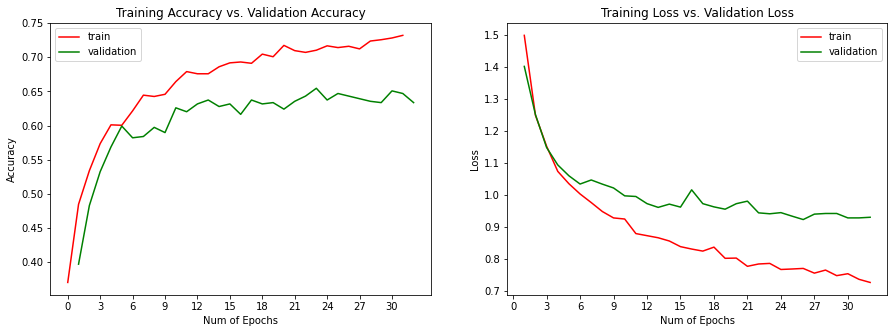

In [ ]:
EPOCHS = 82
plot_model_history('mobile_net', mobile_net_info.history, EPOCHS)

In [ ]:
img_width, img_height = 224, 224
def predict_one_image(img, model):
  img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
  img = np.reshape(img, (1, img_width, img_height, 3))
  img = img/255.
  pred = model.predict(img)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

3
0.6741143
cmd 67%


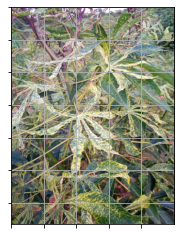

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('train/cgm/train-cgm-50.jpg')
pred, probability = predict_one_image(test_img, mobile_net)
print(pred)
print(probability)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [ ]:
#new_model = tf.keras.models.load_model('My Model/model2tf2')

In [ ]:
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


0
0.916295
cbb 92%


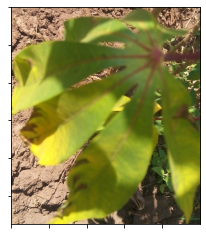

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('test/cbb/cbb-2.jpg')
pred, probability = predict_one_image(test_img, new_model)
print(pred)
print(probability)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid(False)
plt.show()

In [ ]:
new_model2 = tf.keras.models.load_model('My Model/model1tf2.h5')

In [ ]:
new_model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 7, 7, 1280)        0         
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


3
0.73414075
cmd 73%


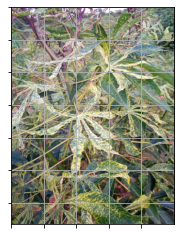

In [ ]:
# idx = 120
# pred, probability = predict_one_image(images[4][idx], model_ResNet50)

test_img = cv2.imread('train/cgm/train-cgm-50.jpg')
pred, probability = predict_one_image(test_img, new_model2)
print(pred)
print(probability)
print('%s %d%%' % (categories[pred], round(probability, 2) * 100))
_, ax = plt.subplots(1)
plt.imshow(cvtRGB(test_img))
# Turn off tick labels
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.grid('off')
plt.show()

In [ ]:
def predict_val(val_data, model):
  val_input = np.reshape(val_data, (1, img_width, img_height, 3))
  val_input = val_input/255.
  pred = model.predict(val_input)
  class_num = np.argmax(pred)
  return class_num, np.max(pred)

In [ ]:
def return_name(label_arr):
  idx = np.where(label_arr == 1)
  return idx[0][0]

Model trained from Mobilenet


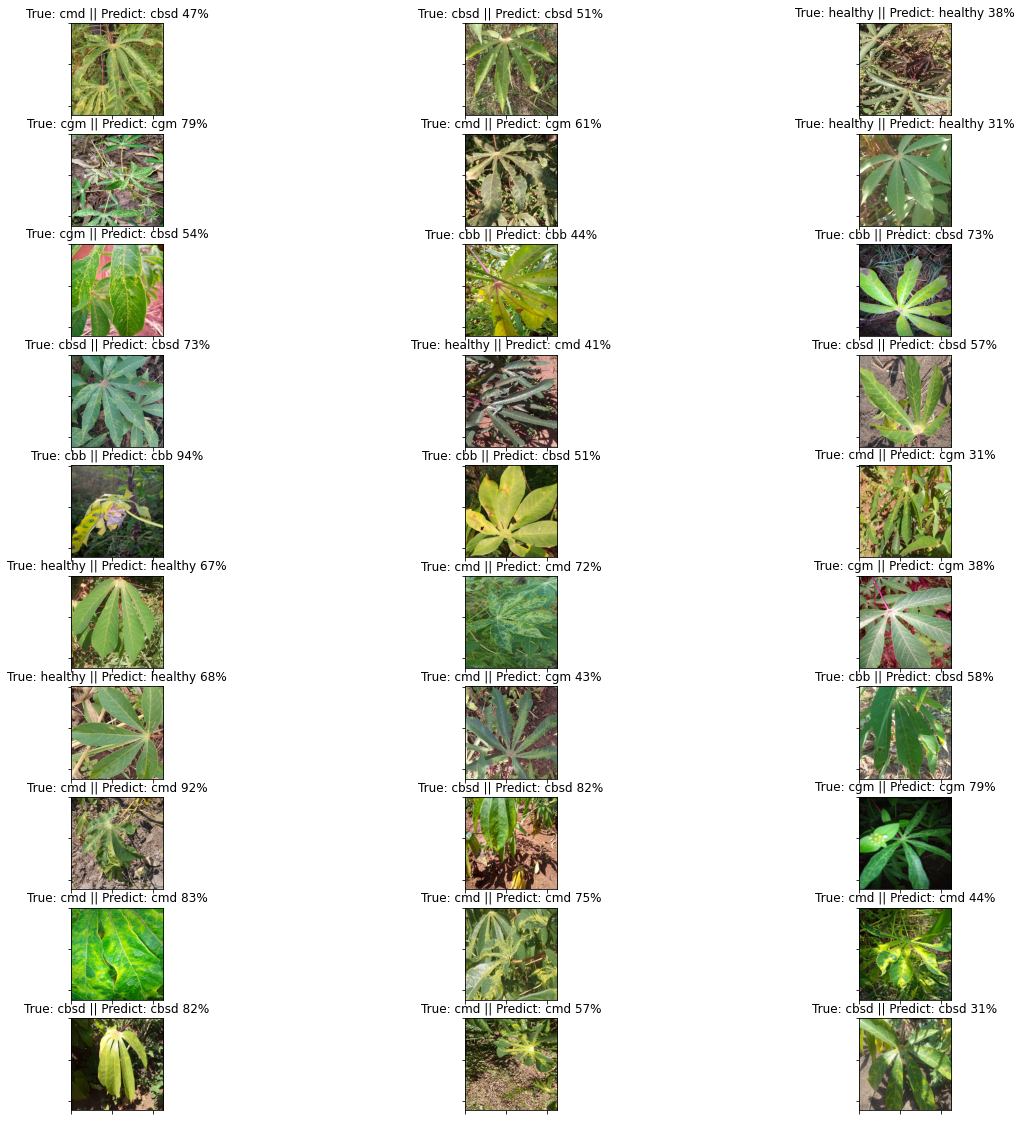

In [ ]:
print("Model trained from Mobilenet")
plt.figure(figsize=(20,20))
for i in range(30):
  
  idx = np.random.randint(300)
  
  ax = plt.subplot(10,3,i+1)
  plt.imshow(cvtRGB(val_data.astype('uint8')[idx]))
  category_idx = return_name(val_labels[idx])
  
  pred, prob = predict_val(val_data[idx], mobile_net)
  plt.title('True: %s || Predict: %s %d%%' % (categories[category_idx], categories[pred], round(prob, 2)*100))
  plt.grid(False)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  
plt.show()

In [ ]:
test_base_path = 'test/'
fnames_test = []
for category in categories:
    test_folder = os.path.join(test_base_path, category)
    file_names = os.listdir(test_folder)
    full_path = [os.path.join(test_folder, file_name) for file_name in file_names]
    fnames_test.append(full_path)

In [ ]:
print('length for each category:', [len(f) for f in fnames_test])

length for each category: [47, 54, 45, 55, 32]


In [ ]:
test_images = []
for names in fnames_test:
    one_category_images = [cv2.imread(name)/255. for name in names if (cv2.imread(name)) is not None]
    test_images.append(one_category_images)

In [ ]:
# Apply resize to all images
img_width, img_height = 224, 224
resized_test_images = []
for i,imgs in enumerate(test_images):
    resized_test_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])



#print(resized_test_images)

In [ ]:
len_test_images = [len(imgs) for imgs in resized_test_images]
print(len_test_images)
print('sum of train images:', np.sum(len_test_images))
test_categories = np.zeros((np.sum(len_test_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        test_categories[:len_test_images[i]] = i
    else:
        test_categories[np.sum(len_test_images[:i]):np.sum(len_test_images[:i+1])] = i

print('test categories ',test_categories )

[47, 54, 45, 55, 32]
sum of train images: 233
test categories  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]


In [ ]:
tmp_test_imgs = []
for imgs in resized_test_images:
    tmp_test_imgs += imgs

test_images = np.array(tmp_test_imgs)

In [ ]:
print('Before converting')
print('test data:', test_images.shape)
print('test labels:', test_categories.shape)

test_data = test_images.astype('float32')
test_labels = np_utils.to_categorical(test_categories, len(categories))

print()
print('After converting')
print('train data:', test_data.shape)
print('train labels:', test_labels.shape)

Before converting
test data: (233, 224, 224, 3)
test labels: (233,)

After converting
train data: (233, 224, 224, 3)
train labels: (233, 5)


In [ ]:
#Memeriksa matriks model
print(new_model.metrics_names)
print ('Evaluasi data training')
print(new_model.evaluate(train_generator))
print ('Evaluasi validasi data')
print(new_model.evaluate(val_generator))
print ('Evaluasi data test')
print(new_model.evaluate(x= test_images, y = test_labels)) 

['loss', 'acc']
Evaluasi data training
49/49 [==============================] - 22s 444ms/step - loss: 0.7730 - acc: 0.7168
[0.7730457782745361, 0.7167519330978394]
Evaluasi validasi data
17/17 [==============================] - 1s 80ms/step - loss: 0.9405 - acc: 0.6546
[0.9405269622802734, 0.6545801758766174]
Evaluasi data test
8/8 [==============================] - 1s 66ms/step - loss: 1.0659 - acc: 0.6052
[1.0659271478652954, 0.6051502227783203]


In [ ]:
#Menampilkan matriks yang benar dan matriks hasil prediksi

#Label yang benar
y_true = np.argmax(test_labels,axis=1)
print('label sebenarnya ',y_true)

#Label prediksi
Y_pred = new_model.predict(test_images)
y_pred = np.argmax(Y_pred, axis=1)
print('label hasil prediksi', y_pred)

label sebenarnya  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4]
label hasil prediksi [0 1 0 0 1 2 2 2 1 3 0 1 0 0 2 0 0 4 0 4 0 3 0 0 1 0 0 4 1 0 0 0 1 2 1 0 0
 0 0 2 0 1 1 0 0 4 2 3 1 0 3 2 0 2 0 0 1 0 3 4 1 1 1 0 1 0 1 1 2 2 1 0 1 1
 1 1 1 0 1 1 1 0 2 1 1 1 3 3 1 1 1 1 1 1 2 0 1 1 1 1 1 4 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 1 4 2 2 1 1 2 2 2 2 3 2 2 3 2 4 2 4 2 2 2 1 2 0 0 3 2 3
 3 2 1 2 3 3 3 3 3 0 1 2 3 1 3 1 3 2 1 3 1 3 2 3 3 3 1 2 3 2 3 3 3 3 3 1 4
 3 1 2 2 3 3 1 0 2 3 2 3 1 3 2 0 0 4 4 4 4 4 0 4 4 4 4 4 4 4 4 1 4 4 4 4 4
 3 4 4 4 4 4 4 4 4 4 1]


Normalized confusion matrix
[[0.51 0.21 0.15 0.04 0.09]
 [0.2  0.57 0.11 0.09 0.02]
 [0.04 0.09 0.71 0.07 0.09]
 [0.05 0.2  0.24 0.49 0.02]
 [0.06 0.06 0.   0.03 0.84]]


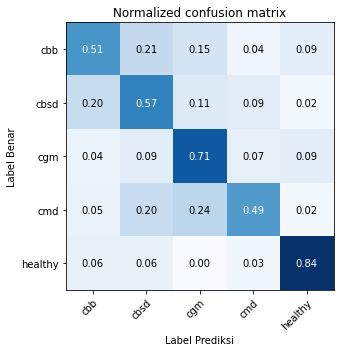

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    #ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Label Benar',
           xlabel='Label Prediksi')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

plot_confusion_matrix(y_true, y_pred, classes=categories, normalize=True,
                      title='Normalized confusion matrix')